## Stock Portfolio allocation Testing Using Stable Basline 3
*   Using Yahoo Finance API to collect End-of-date data for Portfolio allocation
*   Testing applying the trained agents on another set of stocks.



In [ ]:
!apt-get update

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Ign:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [962 kB]
Get:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Ge

# Install neccessary python packages.

In [1]:
!pip install stable-baselines3[extra]
!pip install gym
!pip install yfinance
!pip install pandas
!pip install numpy
!pip install pandas_ta

  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=90a16c0ac32005207f22d2141c202c6f9a2372936312b57ab046d5792705b409
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta


### Data Loading
Collecting data from Yahoo Finance.

In [2]:
import yfinance as yf
import pandas as pd

def get_data_from_yahoo(tic_list, start_date='2009-01-01', end_date='2024-01-01'):
    """
    Fetch OHLCV data from Yahoo Finance for a list of tickers and fill missing data.

    Args:
    - tic_list (list): List of stock tickers.
    - start_date (str): Start date for fetching data.
    - end_date (str): End date for fetching data.

    Returns:
    - pd.DataFrame: DataFrame containing OHLCV data for all tickers with missing data filled.
    """
    # Download historical data for all stocks
    all_df = pd.DataFrame()
    for tic in tic_list:
      df = yf.download(tic, start=start_date, end=end_date)
      df['tic'] = tic
      df = df.ffill()
      all_df = pd.concat([all_df, df])

    all_df = all_df.reset_index()
    all_df = all_df.set_index(['tic'])
    all_df = all_df.sort_index()  # Sort by date and ticker

    return all_df


### Add Technical Indicators and Covariance Matrix

In [3]:
import pandas_ta  as ta # Technical Analysis library, you can install it via pip install pandas_ta
import numpy as np

def add_technical_indicators(df):
    """
    Add common technical indicators and calculate the covariance matrix for each stock pair.

    Args:
    - df (pd.DataFrame): DataFrame with OHLCV data.

    Returns:
    - pd.DataFrame: DataFrame with technical indicators and covariance matrix added.
    """
    # Sort by 'tic' and 'date' just to ensure proper ordering
    df = df.sort_values(by=['tic', 'Date'])

    # Add technical indicators
    df['SMA_10'] = df.groupby('tic')['Close'].transform(lambda x: ta.sma(x, length=10))
    df['SMA_50'] = df.groupby('tic')['Close'].transform(lambda x: ta.sma(x, length=50))
    df['SMA_200'] = df.groupby('tic')['Close'].transform(lambda x: ta.sma(x, length=200))
    df['EMA_10'] = df.groupby('tic')['Close'].transform(lambda x: ta.ema(x, length=10))
    df['RSI_14'] = df.groupby('tic')['Close'].transform(lambda x: ta.rsi(x, length=14))
    df['MACD'], df['MACD_signal'], df['MACD_hist'] = df.groupby('tic')['Close'].apply(lambda x: ta.macd(x, fast=12, slow=26, signal=9)).values.T.tolist()
    bbands = df.groupby('tic')['Close'].apply(lambda x: ta.bbands(x, length=20, std=2))
    df['BBL'], df['BBM'], df['BBU'] = bbands[['BBL_20_2.0', 'BBM_20_2.0', 'BBU_20_2.0']].values.T
    df['ATR_14'] = df.groupby('tic').apply(lambda x: ta.atr(x['High'], x['Low'], x['Close'], length=14)).reset_index(level=0, drop=True)
    df['Stochastic_K'], df['Stochastic_D'] = df.groupby('tic').apply(lambda x: ta.stoch(x['High'], x['Low'], x['Close'], fast_k=14, slow_d=3)).values.T
    df['CCI_14'] = df.groupby('tic').apply(lambda x: ta.cci(x['High'], x['Low'], x['Close'], length=14)).reset_index(level=0, drop=True).tolist()
    df['ADX_14'] = df.groupby('tic').apply(lambda x: ta.adx(x['High'], x['Low'], x['Close'], length=14)).reset_index(level=0, drop=True)[['ADX_14']]
    df['OBV'] = df.groupby('tic').apply(lambda x: ta.obv(x['Close'], x['Volume'])).reset_index(level=0, drop=True).tolist()
    df['WILLR_14'] = df.groupby('tic').apply(lambda x: ta.willr(x['High'], x['Low'], x['Close'], length=14)).reset_index(level=0, drop=True)
    df['ROC_10'] = df.groupby('tic')['Close'].transform(lambda x: ta.roc(x, length=10))
    df['Vortex_Pos'], df['Vortex_Neg'] = df.groupby('tic').apply(lambda x: ta.vortex(x['High'], x['Low'], x['Close'], length=14)).values.T
    df['ATR_14'] = df.groupby('tic').apply(lambda x: ta.atr(x['High'], x['Low'], x['Close'], length=14)).reset_index(level=0, drop=True)

    return df




In [4]:
def add_covariance_matrix(df, tic_list, window=252):
    """
    Calculate the covariance matrix for each stock pair in the given time window.

    Args:
    - df (pd.DataFrame): DataFrame with OHLCV data.
    - tic_list (list): List of stock tickers.
    - window (int): Time window for calculating covariance matrix. default is 252 trading days in a year

    Returns:
    - pd.DataFrame: DataFrame with covariances are added per stock per date
    """

    # Calculate the covariance matrix for the past year for each stock pair
    # We'll use a rolling window of 252 trading days (1 year)
    # window = 252  # 252 trading days in a year
    cov_df = pd.DataFrame()

    # Pivot the data to create a wide-format DataFramce for calculating covariance
    df = df.reset_index()
    Close_prices = df.pivot(index='Date',columns='tic', values='Close')

    for i in range(window, len(Close_prices)):
      cov_matrix = Close_prices.iloc[i-window:i].pct_change().dropna()
      cov_matrix = cov_matrix.cov()
      cov_matrix['Date'] = Close_prices.index[i]
      cov_df = pd.concat([cov_df, cov_matrix])

    cov_df = cov_df.reset_index()
    cov_df = cov_df.set_index(['Date', 'tic'])
    df = df.set_index(['Date', 'tic'])
    # Add the covariance matrix to the DataFrame
    df = pd.concat([df, cov_df], axis=1)

    # Fill any remaining NaNs after adding indicators
    df = df.fillna(0)

    return df


Testing

In [5]:
tic_list = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'BRK-B', 'JNJ', 'V',
            'WMT', 'JPM', 'PG', 'UNH', 'DIS', 'HD', 'MA', 'BAC', 'VZ', 'KO',
            'ADBE', 'NFLX', 'PFE', 'INTC', 'CSCO', 'PEP', 'MRK', 'ABT', 'T', 'XOM']


In [6]:
df = get_data_from_yahoo(tic_list)
df.info()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

<class 'pandas.core.frame.DataFrame'>
Index: 105672 entries, AAPL to XOM
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Date       105672 non-null  datetime64[ns]
 1   Open       105672 non-null  float64       
 2   High       105672 non-null  float64       
 3   Low        105672 non-null  float64       
 4   Close      105672 non-null  float64       
 5   Adj Close  105672 non-null  float64       
 6   Volume     105672 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 6.4+ MB


In [7]:
df = add_technical_indicators(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105672 entries, AAPL to XOM
Data columns (total 28 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Date          105672 non-null  datetime64[ns]
 1   Open          105672 non-null  float64       
 2   High          105672 non-null  float64       
 3   Low           105672 non-null  float64       
 4   Close         105672 non-null  float64       
 5   Adj Close     105672 non-null  float64       
 6   Volume        105672 non-null  int64         
 7   SMA_10        105420 non-null  float64       
 8   SMA_50        104300 non-null  float64       
 9   SMA_200       100100 non-null  float64       
 10  EMA_10        105420 non-null  float64       
 11  RSI_14        105280 non-null  float64       
 12  MACD          104972 non-null  float64       
 13  MACD_signal   104972 non-null  float64       
 14  MACD_hist     104972 non-null  float64       
 15  BBL           105140 n

In [8]:
df = add_covariance_matrix(df, tic_list)
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 105672 entries, (Timestamp('2009-01-02 00:00:00'), 'AAPL') to (Timestamp('2023-12-29 00:00:00'), 'XOM')
Data columns (total 55 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Open          105672 non-null  float64
 1   High          105672 non-null  float64
 2   Low           105672 non-null  float64
 3   Close         105672 non-null  float64
 4   Adj Close     105672 non-null  float64
 5   Volume        105672 non-null  int64  
 6   SMA_10        105672 non-null  float64
 7   SMA_50        105672 non-null  float64
 8   SMA_200       105672 non-null  float64
 9   EMA_10        105672 non-null  float64
 10  RSI_14        105672 non-null  float64
 11  MACD          105672 non-null  float64
 12  MACD_signal   105672 non-null  float64
 13  MACD_hist     105672 non-null  float64
 14  BBL           105672 non-null  float64
 15  BBM           105672 non-null  float64
 16  BBU           10

In [9]:
df.head()

,,Open,High,Low,Close,Adj Close,Volume,SMA_10,SMA_50,SMA_200,EMA_10,...,NVDA,PEP,PFE,PG,T,UNH,V,VZ,WMT,XOM
Date,tic,,,,,,,,,,,,,,,,,,,,,
2009-01-02,AAPL,3.067143,3.251429,3.041429,3.241071,2.737004,746015200,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-05,AAPL,3.327500,3.435000,3.311071,3.377857,2.852516,1181608400,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-06,AAPL,3.426786,3.470357,3.299643,3.322143,2.805468,1289310400,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-07,AAPL,3.278929,3.303571,3.223571,3.250357,2.744846,753048800,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-08,AAPL,3.229643,3.326786,3.215714,3.310714,2.795816,673500800,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Define the GYM env for stock portfolio allocation.


In [10]:
from os import truncate
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd

class PortfolioAllocationEnv(gym.Env):
    """
    Custom Environment that follows gym interface.
    This is a stock portfolio allocation environment.
    """
    def __init__(self, df, initial_balance=10000, tic_list=None, transaction_fee_rate=0.001):
      """
      Initializes the environment.
      df = the stock trading information and features for training the agents.
      initial_balance = the starting balance for creating the portfolio.
      tic_list = the list of stocks to be included in the portfolio.
      """
      super(PortfolioAllocationEnv, self).__init__()

      # Stock Data
      self.df = df
      self.tic_list = tic_list
      self.n_stocks = len(self.tic_list)

      #Initial Setup
      self.initial_balance = initial_balance
      self.balance = initial_balance
      self.current_step = 0
      self.done = False

      # Porfolio Weights (initially all cash)
      self.portfolio_weights = np.array([1] + [0] * self.n_stocks, dtype=float)
      self.holdings = np.zeros(self.n_stocks, dtype=float)
      # current_date = self.df.index.get_level_values(0).unique()[self.current_step]
      # current_data = self.df.loc[current_date]
      # self.prices = current_data['Close'].values
      self.portfolio_value = self.balance

      # Transaction fee rate
      self.transaction_fee_rate = transaction_fee_rate

      # Action Space
      self.action_space = spaces.Box(low=0, high=1, shape=(self.n_stocks + 1,), dtype=np.float64)


      # Observation Space
      # All stocks' technical indicators and covariance matrix are embeded in df.
      # Therefore, the features for a trading day is n_stock * len(df.columns).
      # Amount Cash balance is also included.
      # Portfolio weight is also included, n_stocks + 1, where 1 is the case balance.
      self.observation_space = spaces.Box(
        low=-np.inf,
        high=np.inf,
        shape=(self.n_stocks * len(df.columns) + 1 + self.n_stocks + 1,),
        dtype=np.float64
      )

      # Memory for traking
      self._action_memory = []
      self._portfolio_value_memory = [self.balance]
      self._reward_memory = []
      self._final_weights_memory = [self.portfolio_weights]

    def reset(self, seed=None, options=None):
      """
      Resets the environment to the initial state.
      """
      # Seed the environment (ensure reproducibility)
      if seed is not None:
        np.random.seed(seed)

      # reset environment state
      self.balance = self.initial_balance
      self.current_step = 0
      self.done = False
      self.portfolio_weights = np.array([1] + [0] * self.n_stocks)
      self.holdings = np.zeros(self.n_stocks, dtype=float)
      self.portfolio_value = self.balance
      self._action_memory = []
      self._portfolio_value_memory = [self.balance]
      self._reward_memory = []
      self._final_weights_memory = [self.portfolio_weights]

      # Return the initial observation
      return self._get_observation(), {}

    def step(self, action):
      """
      Execute one time step within the environment.

      Args:
      - action: The portfolio weights (cash + stocks) provided by the agent.

      Returns:
      - observation: The new state after the action.
      - reward: The reward for the current step.
      - done: Whether the episode is over.
      - info: Additional information (empty in this case).
      """
      # Execute the action (rebalance the portfolio)
      current_prices = self._get_close_prices(self.current_step)
      self._take_action(action, current_prices)

      # Advance to the next step
      self.current_step += 1

      # Update the portfolio value and weights after the action
      next_prices = self._get_close_prices(self.current_step)
      self._update_portfolio_value(next_prices)

      # Calculate reward based on the change in portfolio value
      reward = self._calculate_reward()

      # Store the action in memory
      self._action_memory.append(action)
      self._reward_memory.append(reward)  # Store the reward in memory

      # Store the updated portfolio value in memory
      self._portfolio_value_memory.append(self.portfolio_value)

      # Store the updated portfolio weights in memory
      self._final_weights_memory.append(self.portfolio_weights.copy())

      # Check if we're done (end of episode)
      terminated = self.current_step >= len(self.df.index.get_level_values(0).unique()) - 1
      truncated = False  # You can set this to True if you want to truncate the episode

      # Get the new observation
      observation = self._get_observation()

      return observation, reward, terminated, truncated, {}

    def _normalize_action(self, action):
      """
      Normalize the action (weights) to ensure they sum to 1.
      The action represents the target portfolio weights for cash and stocks.

      Args:
      - action: A raw action array of shape (n_stocks + 1,), where the first element
                is the cash allocation and the remaining elements are for the stocks.

      Returns:
      - A normalized action (portfolio weights) that sum to 1.
      """
      # Clip the action to ensure no negative weights (you can adjust this as needed)
      action = np.clip(action, 0, None)

      # Ensure sufficient cash balance at step 0 to pay the transaction fee when initial
      # position setup.
      if (self.current_step == 0):
        if ((action[0] / np.sum(action)) < 0.01): # less than 1% cash
          print(f"Too little cash allocated: {action[0]} / {np.sum(action)}.")
          action[0] = np.sum(action[1:]) / 99 # make cash to be 1%
          

      # Normalize the action so that the sum of the weights equals 1
      normalized_action = action / np.sum(action)

      return normalized_action

    def _get_close_prices(self, step):
      """
      Get the 'Close' prices of all tickers at the specified step (date).
      """
      # Get the current date corresponding to the step
      current_date = self.df.index.get_level_values(0).unique()[step]

      # Filter the DataFrame for this date (all tickers)
      current_data = self.df.loc[current_date]

      # Extract the 'Close' prices for all tickers on the current date
      close_prices = current_data['Close']

      return close_prices

    def _take_action(self, action, current_prices):
      """
      Execute the action (rebalancing), update the number of shares (self.holdings),
      and adjust the cash balance (self.balance), considering transaction fees.

      Args:
      - action: The target portfolio weights provided by the agent.
      - current_prices: The current close prices of the stocks.
      """
      # Normalize the action
      action = self._normalize_action(action)

      # Target cash allocation and stock allocations (dollar amounts)
      target_cash_allocation = action[0] * self.portfolio_value
      target_stock_allocations = action[1:] * self.portfolio_value

      # Current stock allocations (dollar amounts)
      current_stock_allocations = self.holdings * current_prices

      # Deltas represent changes in stock allocations (buy/sell)
      deltas = target_stock_allocations - current_stock_allocations

      # Calculate transaction fees
      transaction_fees = np.abs(deltas) * self.transaction_fee_rate

      # Calculate net cash flow from trades
      net_cash_flow = np.sum(deltas) # Positive: cash needed, Negative: cash generated from selling

      # Total cost includes transaction fees and cash required for buys
      total_transaction_cost = np.sum(transaction_fees) + net_cash_flow

      if total_transaction_cost > self.balance:
          # If there's insufficient cash, reject the action
          # print(f"Insufficient funds. Transaction cost: {total_transaction_cost}, Available cash: {self.balance}")
          return

      # Update holdings (new number of shares for each stock)
      self.holdings = target_stock_allocations / current_prices

      # Update cash balance (account for transaction fees and cash spent/received)
      self.balance -= total_transaction_cost

      # Debug information (optional)
      # print(f"Action taken: {action}")
      # print(f"Target stock allocations: {target_stock_allocations}")
      # print(f"Delta in stock allocations: {deltas}")
      # print(f"Transaction fees: {transaction_fees}")
      # print(f"New cash balance: {self.balance}")
      # print(f"New cash balance: {self.holdings}")
      # print(f"New portfolio weights: {self.portfolio_weights}")

    def _update_portfolio_value(self, current_prices):
      """
      Update the portfolio value based on current stock prices and holdings, and update portfolio weights.

      Args:
      - current_prices: The current close prices of the stocks.
      """
      # Step 1: Calculate the value of stock holdings (number of shares * current prices)
      stock_values = np.sum(self.holdings * current_prices)

      # Step 2: Update the total portfolio value (stock values + cash balance)
      self.portfolio_value = self.balance + stock_values

      # Step 3: Update the portfolio weights based on the new portfolio value
      #         All weights sum up to 1
      self.portfolio_weights[1:] = (self.holdings * current_prices) / self.portfolio_value  # Stock weights
      self.portfolio_weights[0] = self.balance / self.portfolio_value  # Cash weight

    def _calculate_reward(self):
      """
      Calculate the reward based on the change in portfolio value.
      """
      reward = self.portfolio_value / self.initial_balance -1

      return reward


    def _get_observation(self):
      """
      Returns the observation, which includes:
      - Market data: OHLCV, technical indicators, and covariances for all stocks.
      - Portfolio weights and cash balance.
      """
      # Get the current date's data (OHLCV, technical indicators, covariances) for all tickers
      current_date = self.df.index.get_level_values(0).unique()[self.current_step]
      current_data = self.df.loc[current_date]

      # Combine OHLCV, technical indicators, and covariances
      market_data = current_data.values.flatten()
      obs = np.concatenate([
          market_data,
          self.portfolio_weights,
          [self.balance]
      ])

      return obs

    def render(self, mode='human'):
      """
      Render the environment.
      Output useful information like portfolio value, holdings, stock prices, etc.
      """
      if self.current_step >= len(self.df.index.get_level_values(0).unique()) - 1:
        # Calculate and print the portfolio metrics
        metrics = self.calculate_portfolio_metrics()

        print(f"End of Episode Metrics:")
        print(f"Cumulative Return: {metrics['Cumulative Return']:.2f}")
        print(f"Sharpe Ratio: {metrics['Sharpe Ratio']:.2f}")
        print(f"Max Drawdown: {metrics['Max Drawdown']:.2f}")
        print(f"Volatility: {metrics['Volatility']:.2f}")
        print("="*50)

      # Get the current date corresponding to the current step
      current_date = self.df.index.get_level_values(0).unique()[self.current_step]

      # Get the close prices for the current step
      current_prices = self._get_close_prices(self.current_step)

      # Display key information
      print(f"Step: {self.current_step}")
      print(f"Date: {current_date}")
      print(f"Portfolio Value: {self.portfolio_value:.2f}")
      print(f"Cash Balance: {self.balance:.2f}")
      print(f"Stock Prices: {current_prices}")
      print(f"Portfolio Weights: {self.portfolio_weights}")
      print("="*50)

    def _calculate_portfolio_metrics(self):
      """
      Calculate portfolio performance metrics like Sharpe Ratio, Max Drawdown, and Volatility.
      - Cumulative return is based on the final value of the portfolio.
      - Daily returns are calculated from the change in portfolio value between steps.

      Returns:
      - Dictionary with portfolio performance metrics.
      """
      # Convert cumulative rewards to portfolio values
      portfolio_values = np.array(self._portfolio_value_memory)

      # 1. Cumulative Return: Final portfolio value vs. initial balance
      cumulative_return = portfolio_values[-1] / portfolio_values[0] - 1

      # 2. Daily Returns: Compute daily returns from portfolio values
      daily_returns = np.diff(portfolio_values) / portfolio_values[:-1]

      # 3. Sharpe Ratio: Mean return divided by the standard deviation of returns
      mean_return = np.mean(daily_returns)
      std_return = np.std(daily_returns)
      sharpe_ratio = mean_return / (std_return + 1e-6)  # Avoid division by zero

      # 4. Max Drawdown: The maximum drop from peak portfolio value to trough
      peak_value = np.maximum.accumulate(portfolio_values)
      drawdown = (peak_value - portfolio_values) / peak_value
      max_drawdown = np.max(drawdown)

      # 5. Volatility: Standard deviation of daily returns
      volatility = std_return

      return {
          'Cumulative Return': cumulative_return,
          'Sharpe Ratio': sharpe_ratio,
          'Max Drawdown': max_drawdown,
          'Volatility': volatility
      }


### Split the Data from 2010-2019 for training and using 2020-2022 for validation.

In [11]:
# Split the dataset based on the 'Date' or first level of the multi-index
train_df = df.loc[(df.index.get_level_values(0) >= '2010-01-01') & (df.index.get_level_values(0) <= '2019-12-31')]
validation_df = df.loc[(df.index.get_level_values(0) >= '2020-01-01') & (df.index.get_level_values(0) <= '2021-12-31')]
trade_df = df.loc[(df.index.get_level_values(0) >= '2022-01-01') & (df.index.get_level_values(0) <= '2023-12-31')]


### Creating the Environment

### Training the RL Agents
Train multiple RL models such as DQN, PPO, and A2C using the train_env.

*   Here, 'MlpPolicy' is a neural network policy that processes observations (e.g., prices, portfolio weights, etc.) and outputs the actions.
*  total_timesteps=100000 specifies the number of time steps you want to train the models for. You can adjust this depending on the complexity of your environment and desired training length.





In [12]:
from stable_baselines3 import PPO, A2C, DDPG

# Create environment
env = PortfolioAllocationEnv(df=train_df, initial_balance=10000, tic_list=tic_list, transaction_fee_rate=0.001)

# Train PPO
ppo_model = PPO("MlpPolicy", env, verbose=1)
ppo_model.learn(total_timesteps=100000)


2024-09-13 15:27:18.747715: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-13 15:27:18.796526: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-13 15:27:18.809958: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-13 15:27:18.889646: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 199  |
|    iterations      | 1    |
|    time_elapsed    | 10   |
|    total_timesteps | 2048 |
-----------------------------
Too little cash allocated: 0.027381503954529762 / 9.076224097982049.
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.52e+03    |
|    ep_rew_mean          | 76.3        |
| time/                   |             |
|    fps                  | 190         |
|    iterations           | 2           |
|    time_elapsed         | 21          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.017989645 |
|    clip_fraction        | 0.204       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.1       |
|    explained_variance   | 0.157     

In [13]:

# Train A2C
a2c_model = A2C("MlpPolicy", env, verbose=1)
a2c_model.learn(total_timesteps=100000)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| time/                 |          |
|    fps                | 182      |
|    iterations         | 100      |
|    time_elapsed       | 2        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -41.2    |
|    explained_variance | 0        |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -19.7    |
|    std                | 1        |
|    value_loss         | 0.256    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 183      |
|    iterations         | 200      |
|    time_elapsed       | 5        |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -41.3    |
|    explained_variance | 0        |
|    learning_rat

In [14]:

# Train DDPG
ddpg_model = DDPG("MlpPolicy", env, verbose=1)
ddpg_model.learn(total_timesteps=100000)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Too little cash allocated: 0.0 / 11.0.
Too little cash allocated: 0.0 / 11.0.
Too little cash allocated: 0.0 / 11.0.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 2.52e+03  |
|    ep_rew_mean     | 3.53e+03  |
| time/              |           |
|    episodes        | 4         |
|    fps             | 104       |
|    time_elapsed    | 96        |
|    total_timesteps | 10060     |
| train/             |           |
|    actor_loss      | -6.88e+07 |
|    critic_loss     | 3.73e+11  |
|    learning_rate   | 0.001     |
|    n_updates       | 9959      |
----------------------------------
Too little cash allocated: 0.0 / 11.0.
Too little cash allocated: 0.0 / 11.0.
Too little cash allocated: 0.0 / 11.0.
Too little cash allocated: 0.0 / 11.0.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 2.52e+03 |
|    

In [16]:
import os

# Create the directory if it doesn't exist
model_dir = "./IRP/models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


In [17]:
# Save PPO model to the "./models" directory
ppo_model.save(os.path.join(model_dir, "ppo_portfolio_model"))

# Save other models similarly
a2c_model.save(os.path.join(model_dir, "a2c_portfolio_model"))
ddpg_model.save(os.path.join(model_dir, "ddpg_portfolio_model"))


In [45]:
!ls -l ./IRP/models/

total 28120
-rw-r--r-- 1 root root  1773491 Sep 12 16:45 a2c_portfolio_model.zip
-rw-r--r-- 1 root root 24393580 Sep 12 16:45 ddpg_portfolio_model.zip
-rw-r--r-- 1 root root  2623430 Sep 12 16:45 ppo_portfolio_model.zip


In [18]:
# Download historical data for DJI (^DJI) from yfinance
dji_data = yf.download('^DJI', start='2022-01-01', end='2023-12-31')

# Calculate the cumulative returns
dji_cumulative_return = (dji_data['Close'] / dji_data['Close'].iloc[0]) - 1

dji_cumulative_return

[*********************100%***********************]  1 of 1 completed


Date
2022-01-03    0.000000
2022-01-04    0.005866
2022-01-05   -0.004864
2022-01-06   -0.009528
2022-01-07   -0.009660
                ...   
2023-12-22    0.021892
2023-12-26    0.026248
2023-12-27    0.029287
2023-12-28    0.030751
2023-12-29    0.030189
Name: Close, Length: 501, dtype: float64

In [19]:
# Create the test environment
test_env = PortfolioAllocationEnv(df=trade_df, initial_balance=100000, tic_list=tic_list, transaction_fee_rate=0.001)

# Load the trained PPO model
ppo_model = PPO.load(os.path.join(model_dir, "ppo_portfolio_model"), env=test_env)

# Load the trained A2C model
a2c_model = A2C.load(os.path.join(model_dir, "a2c_portfolio_model"), env=test_env)

# Load the trained DDPG model
ddpg_model = DDPG.load(os.path.join(model_dir, "ddpg_portfolio_model"), env=test_env)


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [20]:
def test_agent_performance(agent, env):
    """
    Test the agent on the test dataset and track portfolio values indexed by date.
    """
    obs, _ = env.reset()
    done = False

    # Initialize a dictionary to store portfolio values indexed by date
    portfolio_values = {}
    
    # Get the list of dates from the test environment's dataframe (index level 0)
    dates = env.df.index.get_level_values(0).unique()

    # Add the initial portfolio value with the first date
    portfolio_values[dates[0]] = env.initial_balance

    step = 0
    while not done:
        action, _ = agent.predict(obs)
        obs, reward, done, truncated, _ = env.step(action)
        step += 1

        # Record the portfolio value for the current date
        portfolio_values[dates[step]] = env.portfolio_value

    # Convert the dictionary to a Pandas Series for easy plotting and comparison
    portfolio_values_series = pd.Series(portfolio_values)

    # Calculate cumulative return
    cumulative_return = (portfolio_values_series[-1] / portfolio_values_series[0]) - 1

    return portfolio_values_series, cumulative_return


In [21]:
# Test PPO model on the test data
ppo_portfolio_values, ppo_cumulative_return = test_agent_performance(ppo_model, test_env)

# Test A2C model on the test data
a2c_portfolio_values, a2c_cumulative_return = test_agent_performance(a2c_model, test_env)

# Test DDPG model on the test data
ddpg_portfolio_values, ddpg_cumulative_return = test_agent_performance(ddpg_model, test_env)


Too little cash allocated: 0.0 / 8.449148818850517.


/tmp/ipykernel_12/2452626148.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cumulative_return = (portfolio_values_series[-1] / portfolio_values_series[0]) - 1


Too little cash allocated: 0.0 / 9.04982978105545.
Too little cash allocated: 0.0 / 11.0.


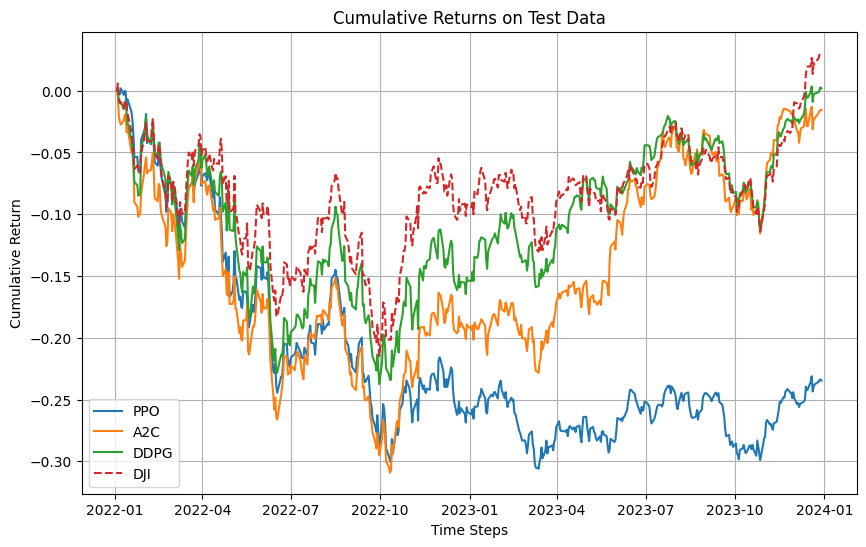

In [22]:
import matplotlib.pyplot as plt

# Calculate cumulative returns for each agent over time
ppo_cumulative_returns = (ppo_portfolio_values / ppo_portfolio_values.iloc[0]) - 1
a2c_cumulative_returns = (a2c_portfolio_values / a2c_portfolio_values.iloc[0]) - 1
ddpg_cumulative_returns = (ddpg_portfolio_values / ddpg_portfolio_values.iloc[0]) - 1

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(ppo_cumulative_returns, label="PPO")
plt.plot(a2c_cumulative_returns, label="A2C")
plt.plot(ddpg_cumulative_returns, label="DDPG")

# Add DJI benchmark cumulative returns (assuming you already have it)
plt.plot(dji_cumulative_return, label="DJI", linestyle="--")

plt.title("Cumulative Returns on Test Data")
plt.xlabel("Time Steps")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()


## Split the data set into 2 for testing Continual Learning techniques

### Splitting Data Set
The original data set will be split into 2.  Each contains the trading data of 14 stocks, which are selected randomly for each run.  The another 14 stocks' data will be used to test the performance after applying Continual Learning techniques.

### Continual Learning Techniques
1. Naive -  Just training the agents with additional data of the second half of the data.
2. Regulationization - Which apply controls how the update apply during learning of new data.
3. Experience Replay - Part of the original set of data will be replayed during the training using the new data.

In [23]:
import random

def split_collect_stock_data(tic_list, start_date='2009-01-01', end_date='2024-01-01'):
    """
    The function is to randomly generate 2 sets of stock trading data.
    
    Parameters:
    tic_list : A list of all stocks for collecting trading data
    start_date : The start date of the trading data
    end_date: The end date of the trading data

    Returns:
    group1, group2: the tickers list of the 2 data sets.
    df1, df2: 2 dataframes contain the trading data, technical indicators, and covariance.
    """

    tic_list_copy = tic_list.copy()
    random.shuffle(tic_list_copy)
    index = int(len(tic_list_copy)/2)
    group1 = tic_list_copy[:index]
    group2 = tic_list_copy[index:2*index]

    df1 = get_data_from_yahoo(group1, start_date, end_date)
    df1 = add_technical_indicators(df1)
    df1 = add_covariance_matrix(df1, group1)

    df2 = get_data_from_yahoo(group2, start_date, end_date)
    df2 = add_technical_indicators(df2)
    df2 = add_covariance_matrix(df2, group2)

    return group1, group2, df1, df2



In [24]:
group1,group2, df1, df2 = split_collect_stock_data(tic_list)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

### Split 2 sets of data into train, validation, and trade data sets

In [25]:
# Split the dataset based on the 'Date' or first level of the multi-index
train_df1 = df1.loc[(df1.index.get_level_values(0) >= '2010-01-01') & (df1.index.get_level_values(0) <= '2019-12-31')]
validation_df1 = df1.loc[(df1.index.get_level_values(0) >= '2020-01-01') & (df1.index.get_level_values(0) <= '2021-12-31')]
trade_df1 = df1.loc[(df1.index.get_level_values(0) >= '2022-01-01') & (df1.index.get_level_values(0) <= '2023-12-31')]

train_df2 = df2.loc[(df2.index.get_level_values(0) >= '2010-01-01') & (df2.index.get_level_values(0) <= '2019-12-31')]
validation_df2 = df2.loc[(df2.index.get_level_values(0) >= '2020-01-01') & (df2.index.get_level_values(0) <= '2021-12-31')]
trade_df2 = df2.loc[(df2.index.get_level_values(0) >= '2022-01-01') & (df2.index.get_level_values(0) <= '2023-12-31')]

In [35]:
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.005,
    "learning_rate": 0.0001,
    "batch_size": 128,
}

A2C_PARAMS = {
    "n_steps": 5, 
    "ent_coef": 0.005, 
    "learning_rate": 0.0002
}

DDPG_PARAMS = {
    "batch_size": 128, 
    "buffer_size": 50000, 
    "learning_rate": 0.001
}

In [44]:
from stable_baselines3 import PPO, A2C, DDPG

# Create environment
env = PortfolioAllocationEnv(df=train_df1, initial_balance=100000, tic_list=group1, transaction_fee_rate=0.001)

# Train PPO
ppo_model = PPO("MlpPolicy", env, verbose=1, **PPO_PARAMS)
ppo_model.learn(total_timesteps=100000)


# Train A2C
a2c_model = A2C("MlpPolicy", env, verbose=1, **A2C_PARAMS)
a2c_model.learn(total_timesteps=80000)

# Train DDPG
ddpg_model = DDPG("MlpPolicy", env, verbose=1, **DDPG_PARAMS)
ddpg_model.learn(total_timesteps=50000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Too little cash allocated: 0.0 / 6.870041556656361.
-----------------------------
| time/              |      |
|    fps             | 271  |
|    iterations      | 1    |
|    time_elapsed    | 7    |
|    total_timesteps | 2048 |
-----------------------------
Too little cash allocated: 0.0 / 4.018470048904419.
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.52e+03    |
|    ep_rew_mean          | -533        |
| time/                   |             |
|    fps                  | 264         |
|    iterations           | 2           |
|    time_elapsed         | 15          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008329565 |
|    clip_fraction        | 0.0829      |
|    clip_range           | 0.2         |
|    entropy_loss         | -21.3       |
|  

/tmp/ipykernel_12/3129755782.py:158: RuntimeWarning: invalid value encountered in divide
  normalized_action = action / np.sum(action)


Too little cash allocated: 0.0 / 4.040383726358414.
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.52e+03    |
|    ep_rew_mean          | -293        |
| time/                   |             |
|    fps                  | 259         |
|    iterations           | 10          |
|    time_elapsed         | 78          |
|    total_timesteps      | 20480       |
| train/                  |             |
|    approx_kl            | 0.007527823 |
|    clip_fraction        | 0.0475      |
|    clip_range           | 0.2         |
|    entropy_loss         | -21.3       |
|    explained_variance   | -0.318      |
|    learning_rate        | 0.0001      |
|    loss                 | 0.355       |
|    n_updates            | 90          |
|    policy_gradient_loss | -0.0104     |
|    std                  | 1           |
|    value_loss           | 2.47        |
-----------------------------------------
------------------------

In [45]:
# Save PPO model to the "./models" directory
ppo_model.save(os.path.join(model_dir, "ppo_portfolio_model_group1_v1"))

# Save other models similarly
a2c_model.save(os.path.join(model_dir, "a2c_portfolio_model_group1_v1"))
ddpg_model.save(os.path.join(model_dir, "ddpg_portfolio_model_group1_v1"))

In [46]:
!ls -l ./IRP/models/

total 41292
-rw-r--r-- 1 root root  1773491 Sep 13 16:03 a2c_portfolio_model.zip
-rw-r--r-- 1 root root   740238 Sep 13 17:15 a2c_portfolio_model_group1_v1.zip
-rw-r--r-- 1 root root 24393580 Sep 13 16:03 ddpg_portfolio_model.zip
-rw-r--r-- 1 root root 11659391 Sep 13 17:15 ddpg_portfolio_model_group1_v1.zip
-rw-r--r-- 1 root root  2623430 Sep 13 16:03 ppo_portfolio_model.zip
-rw-r--r-- 1 root root  1085036 Sep 13 17:15 ppo_portfolio_model_group1_v1.zip


In [47]:
# Create the test environment
test_env = PortfolioAllocationEnv(df=trade_df1, initial_balance=100000, tic_list=group1, transaction_fee_rate=0.001)

# Load the trained PPO model
ppo_model = PPO.load(os.path.join(model_dir, "ppo_portfolio_model_group1_v1"), env=test_env)

# Load the trained A2C model
a2c_model = A2C.load(os.path.join(model_dir, "a2c_portfolio_model_group1_v1"), env=test_env)

# Load the trained DDPG model
ddpg_model = DDPG.load(os.path.join(model_dir, "ddpg_portfolio_model_group1_v1"), env=test_env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [48]:
# Test PPO model on the test data
ppo_group1_v1_portfolio_values, ppooup_group1_v1_cumulative_return = test_agent_performance(ppo_model, test_env)

# Test A2C model on the test data
a2c_group1_v1_portfolio_values, a2c_group1_v1_cumulative_return = test_agent_performance(a2c_model, test_env)

# Test DDPG model on the test data
ddpg_group1_v1_portfolio_values, ddpg_group1_v1_cumulative_return = test_agent_performance(ddpg_model, test_env)

Too little cash allocated: 0.0 / 6.469865515828133.


/tmp/ipykernel_12/2452626148.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cumulative_return = (portfolio_values_series[-1] / portfolio_values_series[0]) - 1


In [49]:
# Create the test environment
test_env = PortfolioAllocationEnv(df=trade_df2, initial_balance=100000, tic_list=group2, transaction_fee_rate=0.001)

# Load the trained PPO model
ppo_model = PPO.load(os.path.join(model_dir, "ppo_portfolio_model_group1_v1"), env=test_env)

# Load the trained A2C model
a2c_model = A2C.load(os.path.join(model_dir, "a2c_portfolio_model_group1_v1"), env=test_env)

# Load the trained DDPG model
ddpg_model = DDPG.load(os.path.join(model_dir, "ddpg_portfolio_model_group1_v1"), env=test_env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [50]:
# Test PPO model on the test data
ppo_group2_v1_portfolio_values, ppo_group2_v1_cumulative_return = test_agent_performance(ppo_model, test_env)

# Test A2C model on the test data
a2c_group2_v1_portfolio_values, a2c_group2_v1_cumulative_return = test_agent_performance(a2c_model, test_env)

# Test DDPG model on the test data
ddpg_group2_v1_portfolio_values, ddpg_group2_v1_cumulative_return = test_agent_performance(ddpg_model, test_env)

Too little cash allocated: 0.0 / 4.522446125745773.


/tmp/ipykernel_12/2452626148.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cumulative_return = (portfolio_values_series[-1] / portfolio_values_series[0]) - 1


Too little cash allocated: 0.0 / 4.446894124150276.


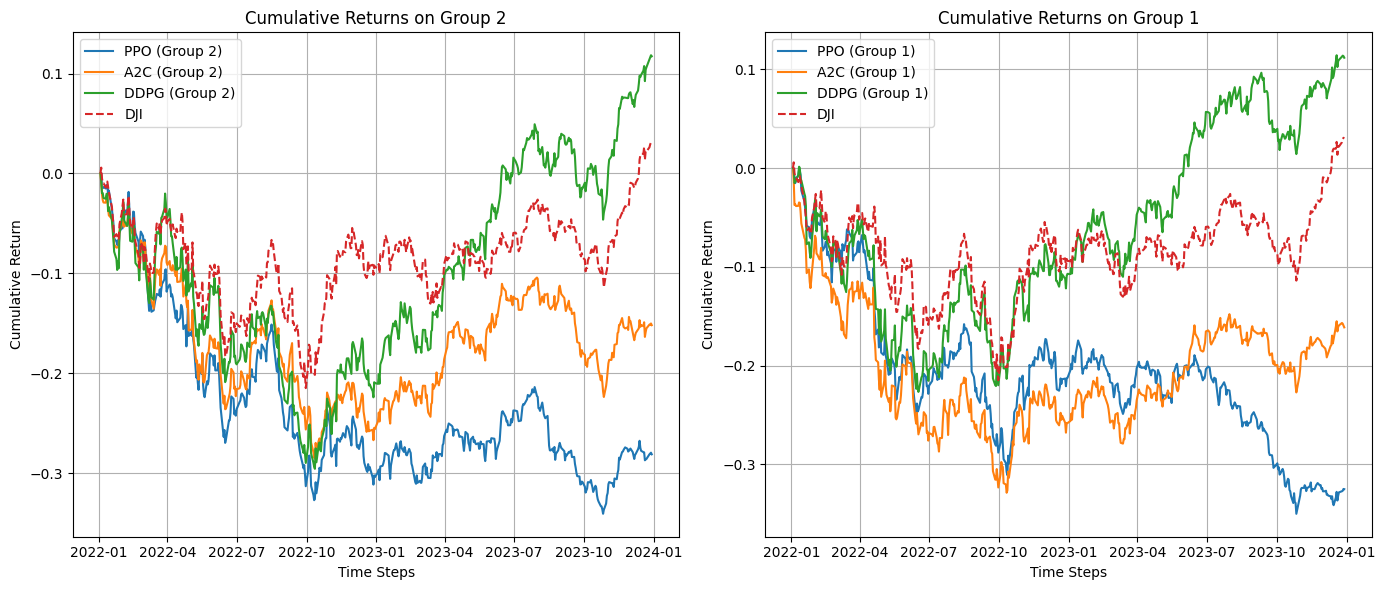

In [51]:
import matplotlib.pyplot as plt

# Calculate cumulative returns for each agent over time
ppo_cumulative_returns = (ppo_group2_v1_portfolio_values / ppo_group2_v1_portfolio_values.iloc[0]) - 1
a2c_cumulative_returns = (a2c_group2_v1_portfolio_values / a2c_group2_v1_portfolio_values.iloc[0]) - 1
ddpg_cumulative_returns = (ddpg_group2_v1_portfolio_values / ddpg_group2_v1_portfolio_values.iloc[0]) - 1

# Calculate cumulative returns for Group 1 (similar to how you did for Group 2)
ppo_cumulative_returns_group1 = (ppo_group1_v1_portfolio_values / ppo_group1_v1_portfolio_values.iloc[0]) - 1
a2c_cumulative_returns_group1 = (a2c_group1_v1_portfolio_values / a2c_group1_v1_portfolio_values.iloc[0]) - 1
ddpg_cumulative_returns_group1 = (ddpg_group1_v1_portfolio_values / ddpg_group1_v1_portfolio_values.iloc[0]) - 1

# Create subplots: 1 row, 2 columns
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot Group 2 cumulative returns
axs[0].plot(ppo_cumulative_returns, label="PPO (Group 2)")
axs[0].plot(a2c_cumulative_returns, label="A2C (Group 2)")
axs[0].plot(ddpg_cumulative_returns, label="DDPG (Group 2)")
axs[0].plot(dji_cumulative_return, label="DJI", linestyle="--")

axs[0].set_title("Cumulative Returns on Group 2")
axs[0].set_xlabel("Time Steps")
axs[0].set_ylabel("Cumulative Return")
axs[0].legend()
axs[0].grid(True)

# Plot Group 1 cumulative returns
axs[1].plot(ppo_cumulative_returns_group1, label="PPO (Group 1)")
axs[1].plot(a2c_cumulative_returns_group1, label="A2C (Group 1)")
axs[1].plot(ddpg_cumulative_returns_group1, label="DDPG (Group 1)")
axs[1].plot(dji_cumulative_return, label="DJI", linestyle="--")

axs[1].set_title("Cumulative Returns on Group 1")
axs[1].set_xlabel("Time Steps")
axs[1].set_ylabel("Cumulative Return")
axs[1].legend()
axs[1].grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()